In [1]:
import os
from nilearn import datasets, plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Generating the brain atlas
atlas = datasets.fetch_atlas_aal()
atlas_filename = atlas.maps
labels = atlas.labels

# Finding the coordinates of the brain segments
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas.maps)

# Making a dictionary out of the positions of the brain segments and the positions in MNI space
brain_segments_pos = {}
for idx, val in enumerate(atlas.labels):
    brain_segments_pos[val] = list(np.around(coordinates[idx],2))

In [3]:
# Here I start with the ADNI_full folder with the time_series folder already generated, so I only need to load the time series
def load_time_series():
    root = 'ADNI_full/time_series'
    time_series_list = os.listdir(root)
    time_series=[]
    for i in time_series_list:
        time_series_sub = np.loadtxt(os.path.join(root, i), delimiter=',')
        time_series.append(time_series_sub)
    return time_series

In [4]:
# Make the list of time series into a list of df
def time_series_to_df(time_series):
    df_time_series = []
    for i in time_series:
        df = pd.DataFrame(i)
        df_time_series.append(df)
    return df_time_series

In [5]:
# Defining the different correlation relations to build the correlation matrix.
# We also set the diagonal to 0 to avoid bias and the NaN values to 0.

def pearson_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='pearson').fillna(0)
        np.fill_diagonal(corr_df.values, 0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def spearman_rank_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='spearman').fillna(0)
        np.fill_diagonal(corr_df.values, 0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def kendall_rank_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='kendall').fillna(0)
        np.fill_diagonal(corr_df.values, 0)
        corr_matrices.append(corr_df.to_numpy())
    return corr_matrices

def partial_corr(df_time_series):
    corr_matrices = []
    for df in df_time_series:
        corr_df = df.corr(method='pearson').fillna(0)
        n = corr_df.shape[0]
        partial_corr_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                partial_corr_matrix[i, j] = -corr_df.iloc[i, j] / np.sqrt(corr_df.iloc[i, i] * corr_df.iloc[j, j])
        np.fill_diagonal(partial_corr_matrix, 0)
        corr_matrices.append(partial_corr_matrix)
    return corr_matrices

In [6]:
# Plot the correlation matrix
def plot_corr(corr_matrix, method):
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(f'{method} Correlation Matrix')
    plt.show()

In [7]:
# Loading the time_series and building the df of time_series
time_series = load_time_series()
df_time_series = time_series_to_df(time_series)

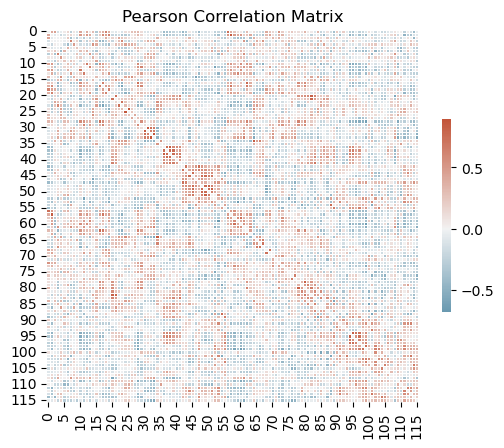

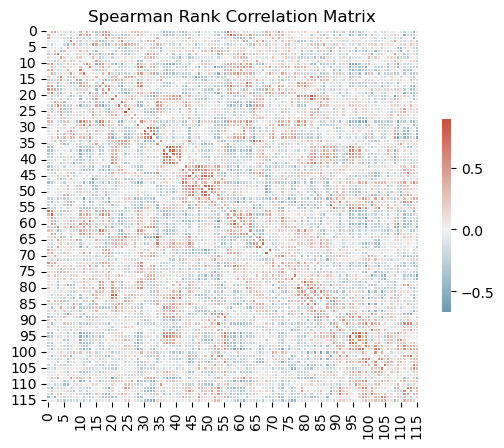

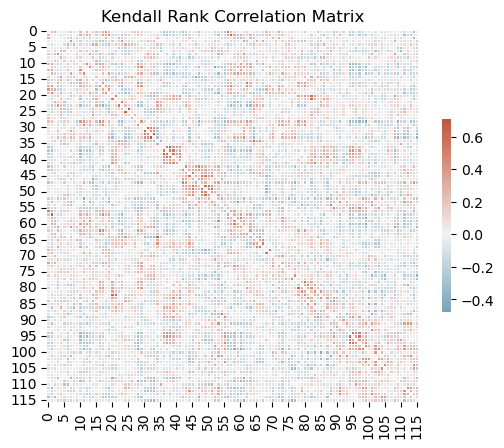

/var/folders/wh/snjqmpvj7qv64q1ngy8zvqbh0000gn/T/ipykernel_34540/745267024.py:36: RuntimeWarning: invalid value encountered in scalar divide
  partial_corr_matrix[i, j] = -corr_df.iloc[i, j] / np.sqrt(corr_df.iloc[i, i] * corr_df.iloc[j, j])


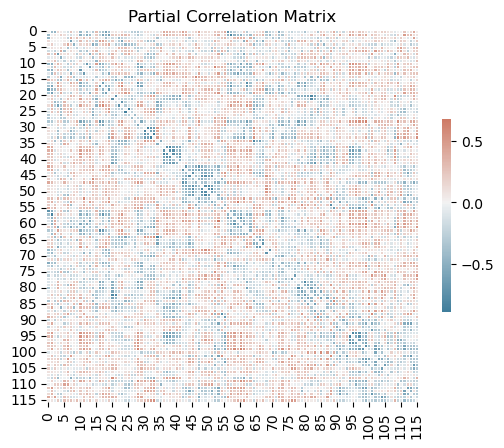

In [8]:
# Generating the correlation matrices
idx_patient = 20

# Using the pearson correlation function
corr_matrix_pearson = pearson_corr(df_time_series)
plot_corr(corr_matrix_pearson[idx_patient], 'Pearson')

# Using the spearman rank correlation function
corr_matrix_spearman = spearman_rank_corr(df_time_series)
plot_corr(corr_matrix_spearman[idx_patient], 'Spearman Rank')

# Using the kendall rank correlation function
corr_matrix_kendall = kendall_rank_corr(df_time_series)
plot_corr(corr_matrix_kendall[idx_patient], 'Kendall Rank')

# Using the partial correlation function
corr_matrix_partial = partial_corr(df_time_series)
plot_corr(corr_matrix_partial[idx_patient], 'Partial')

In [9]:
# Compare the differences between all the matrices. Here I am using the Frobenius norm to measure the element-wise differences.

matrices = [corr_matrix_pearson[idx_patient], corr_matrix_spearman[idx_patient], corr_matrix_kendall[idx_patient], corr_matrix_partial[idx_patient]]

def compare_correlation_matrices(matrices):
    num_matrices = len(matrices)
    dissimilarities = np.zeros((num_matrices, num_matrices))
    for i in range(num_matrices):
        for j in range(i+1, num_matrices):
            diff_matrix = matrices[i] - matrices[j]
            frobenius_norm = np.linalg.norm(diff_matrix, ord='fro')
            dissimilarities[i, j] = frobenius_norm
            dissimilarities[j, i] = frobenius_norm
    return dissimilarities

# Compare matrices
dissimilarities = compare_correlation_matrices(matrices)
print("Dissimilarities between correlation matrices:")
print(dissimilarities)

Dissimilarities between correlation matrices:
[[ 0.          4.0157538   9.97899635 55.63585726]
 [ 4.0157538   0.          8.3128964  54.33461741]
 [ 9.97899635  8.3128964   0.         46.08854393]
 [55.63585726 54.33461741 46.08854393  0.        ]]


In [10]:
# Saving all the Correlation Matrices
def save_matrix(corr_matrix, method):
    directory = f'ADNI_full/corr_matrices/corr_matrix_{method}/'
    os.makedirs(directory, exist_ok=True)
    for idx_patient in range(len(corr_matrix)):
        np.savetxt(f'{directory}patient_{idx_patient}.csv', corr_matrix[idx_patient], delimiter=',')
    return None

save_matrix(corr_matrix_pearson, 'pearson')
save_matrix(corr_matrix_spearman, 'spearman')
save_matrix(corr_matrix_kendall, 'kendall')
save_matrix(corr_matrix_partial, 'partial')

In [11]:
# Creating the dataframe with the time series, the correlation matrices and the diagnostic label for each patient
def create_df(time_series, corr_matrix_methods_list, corr_matrix_methods_names, diagnostic_label):
    df = pd.DataFrame()
    df['patient_id'] = range(len(diagnostic_label))
    df['time_series'] = time_series
    for i in range(len(corr_matrix_methods_list)):
        corr_matrix = corr_matrix_methods_list[i]
        method = corr_matrix_methods_names[i]
        df[f'corr_matrix_{method}'] = corr_matrix
    df['diagnostic_label'] = diagnostic_label
    return df

# Loading the diagnostic label
diagnostic_label = pd.read_csv('ADNI_full/diagnostic_label.csv', header=None)
corr_matrix_methods_list = [corr_matrix_pearson, corr_matrix_spearman , corr_matrix_kendall, corr_matrix_partial]
corr_matrix_methods_names = ['pearson', 'spearman', 'kendall', 'partial']
full_df = create_df(df_time_series, corr_matrix_methods_list, corr_matrix_methods_names, diagnostic_label)

In [16]:
# Visualizing a few features of the dataframe
print(f'Headers of the dataframe: \n', ', '.join(full_df.columns), '\n')
print(f'First 5 rows of the dataframe: \n', full_df.head(), '\n')
print(f'The shape of the dataframe: \n', full_df.shape, '\n')
print(f'The diagnostic label distribution: \n', full_df['diagnostic_label'].value_counts(), '\n')
print(f'The time series of the first patient: \n', full_df['time_series'][0], '\n')
print(f'The number of patients: \n', full_df['patient_id'])

Headers of the dataframe: 
 patient_id, time_series, corr_matrix_pearson, corr_matrix_spearman, corr_matrix_kendall, corr_matrix_partial, diagnostic_label 

First 5 rows of the dataframe: 
    patient_id                                        time_series  \
0           0            0         1         2         3     ...   
1           1            0         1         2         3     ...   
2           2            0         1         2         3     ...   
3           3            0         1         2         3     ...   
4           4            0         1         2         3     ...   

                                 corr_matrix_pearson  \
0  [[0.0, 0.8056247552530764, 0.46635803030073997...   
1  [[0.0, 0.5790744332365937, 0.3135117294185946,...   
2  [[0.0, 0.6490690879701971, 0.14739383709840614...   
3  [[0.0, 0.5434989760459465, -0.0721394345432629...   
4  [[0.0, 0.6794114694061416, 0.4750765976841186,...   

                                corr_matrix_spearman  \
0  [[0.0